In [1]:
"""
Author: Bryan Bo Cao
Email: boca7588@colorado.edu or bo.cao-1@colorado.edu
Github Repo: https://github.com/BryanBo-Cao/neuralnets-deeplearning
Reference:
    http://www.deeplearning.net/tutorial/lstm.html#lstm
    https://github.com/llSourcell/LSTM_Networks/blob/master/LSTM%20Demo.ipynb
    https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/recurrent_network.py
    Recurrent Neural Network.
    A Recurrent Neural Network (LSTM) implementation example using TensorFlow library.
    This example is using the MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/)
    Links:
    [Long Short Term Memory](http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf)
    [MNIST Dataset](http://yann.lecun.com/exdb/mnist/).
    Author: Aymeric Damien
    Project: https://github.com/aymericdamien/TensorFlow-Examples/
"""
from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from importlib import import_module

H = 25
N = 25

#Reference: Denis
def generate_parity_sequences(N, count):
    """
    Generate :count: sequences of length :N:.
    If odd # of 1's -> output 1
    else -> output 0
    """
    xor = lambda x: 1 if (x % 2 == 1) else 0
    sequences = np.random.choice([0, 1], size=[count, N], replace=True)
    counts = np.count_nonzero(sequences == 1, axis=1)
    # xor each sequence, expand dimensions by 1 to match sequences shape
    y = np.expand_dims(np.array([xor(x) for x in counts]), axis=1)

    # In case if you wanted to have the answer just appended at the end of the sequence:
    #     # append the answer at the end of each sequence
    #     seq_plus_y = np.concatenate([sequences, y], axis=1)
    #     print(sequences.shape, y.shape, seq_plus_y.shape)
    #     return seq_plus_y
    return np.expand_dims(sequences, axis=2), y

#Reference: Modified from Denis by Bo Cao
def generate_parity_sequences(N, count):
    """
    Generate :count: sequences of length :N:.
    If odd # of 1's -> output 1
    else -> output 0
    """
    xor = lambda x: 1 if (x % 2 == 1) else 0
    sequences = np.random.choice([0, 1], size=[count, N], replace=True)
    counts = np.count_nonzero(sequences == 1, axis=1)
    # xor each sequence, expand dimensions by 1 to match sequences shape
    y = np.expand_dims(np.array([xor(x) for x in counts]), axis=1)

    # In case if you wanted to have the answer just appended at the end of the sequence:
    #     # append the answer at the end of each sequence
    #     seq_plus_y = np.concatenate([sequences, y], axis=1)
    #     print(sequences.shape, y.shape, seq_plus_y.shape)
    #     return seq_plus_y
    
    new_y = []
    for i in range(len(y)):
        new_yy = []
        if y[i] == 0:
            new_yy.append(0)
            new_yy.append(1)
        else:
            new_yy.append(1)
            new_yy.append(0)
        new_y.append(new_yy)

    return np.expand_dims(sequences, axis=2), new_y

In [2]:
# Training Parameters
learning_rate = 0.45
batch_size = 128
display_step = batch_size * 100

#batch_steps = 10000 / batch_size
epochs = 5000

# Network Parameters
num_input = 1 # 
timesteps = N # timesteps
num_hidden = H # hidden layer num of features
num_classes = 2 # 0 or 1

# tf Graph input
X = tf.placeholder("float", [None, timesteps, num_input])
Y = tf.placeholder("float", [None, num_classes])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}


def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)

    # Get lstm cell output
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

logits = RNN(X, weights, biases)
#prediction = tf.nn.softmax(logits)
prediction = tf.tanh(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

test_accuracies_10replications = []
losses_1st_replication = [] #epoch as unit
test_accuracies_1st_replication = [] #epoch as unit
train_accuracies_1st_replication = [] #epoch as unit

# Start training
with tf.Session() as sess:
    
    # Run 10 replications
    for replication in range(10):
        
        print("Replication: %d: " % replication)
        
        # Initialize random weights
        train_data = generate_parity_sequences(N, 10000)
        train_data_x = train_data[0]
        train_data_y = train_data[1]
        test_data = generate_parity_sequences(N, 10000)
        test_data_x = test_data[0]
        test_data_y = test_data[1]
        
        # Run the initializer
        sess.run(init)
    
        for epoch in range(epochs):
            batch_index = 0
            while batch_index < 10000:

                train_data_batch_x = []
                train_data_batch_y = []
                if batch_index + batch_size < 10000: 
                    train_data_batch_x = train_data_x[batch_index : batch_index + batch_size]
                    train_data_batch_y = train_data_y[batch_index : batch_index + batch_size]
                else:
                    train_data_batch_x = train_data_x[batch_index : ]
                    train_data_batch_y = train_data_y[batch_index : ]

                #batch_x, batch_y = mnist.train.next_batch(batch_size)
                # Reshape data to get 28 seq of 28 elements
                #batch_x = batch_x.reshape((batch_size, timesteps, num_input))
                #train_data_x = train_data_x.reshape((10000, timesteps, num_input))
                #print("train_data_batch_x.shape:  " , train_data_batch_x.shape)
                if batch_index + batch_size < 10000: 
                    train_data_batch_x = train_data_batch_x.reshape((batch_size, timesteps, num_input))
                else:
                    train_data_batch_x = train_data_batch_x.reshape((10000 % batch_size, timesteps, num_input))
                # Run optimization op (backprop)
                #sess.run(train_op, feed_dict={X: train_data_x, 
                 #                             Y: train_data_y})
                sess.run(train_op, feed_dict={X: train_data_batch_x, 
                                              Y: train_data_batch_y})

                batch_index += batch_size

            if replication == 0:
                loss, train_accuracy = sess.run([loss_op, accuracy], feed_dict={X: train_data_x, Y: train_data_y})
                test_accuracy = sess.run(accuracy, feed_dict={X: test_data_x, Y: test_data_y})
                losses_1st_replication.append(loss)
                train_accuracies_1st_replication.append(train_accuracy)
                test_accuracies_1st_replication.append(test_accuracy)
            
            if epoch % 10 == 0:
                loss, acc = sess.run([loss_op, accuracy], feed_dict={X: train_data_x,
                                                                         Y: train_data_y})
                print("Epoch: " + str(epoch) + \
                          ", Loss= " + \
                          "{:.4f}".format(loss) + ", Training Accuracy= " + \
                          "{:.3f}".format(acc))

        print("Optimization Finished!")

        test_data_x = test_data_x.reshape((-1, timesteps, num_input))
        test_data_y = test_data_y
        test_accuracy = sess.run(accuracy, feed_dict={X: test_data_x, Y: test_data_y})
        test_accuracies_10replications.append(test_accuracy)
        print("Testing Accuracy:", test_accuracy)

Replication: 0: 
Epoch: 0, Loss= 0.7656, Training Accuracy= 0.502
Epoch: 10, Loss= 0.7197, Training Accuracy= 0.502
Epoch: 20, Loss= 0.7136, Training Accuracy= 0.502
Epoch: 30, Loss= 0.7108, Training Accuracy= 0.502
Epoch: 40, Loss= 0.7090, Training Accuracy= 0.502
Epoch: 50, Loss= 0.7078, Training Accuracy= 0.502
Epoch: 60, Loss= 0.7069, Training Accuracy= 0.502
Epoch: 70, Loss= 0.7062, Training Accuracy= 0.502
Epoch: 80, Loss= 0.7056, Training Accuracy= 0.502
Epoch: 90, Loss= 0.7051, Training Accuracy= 0.502
Epoch: 100, Loss= 0.7047, Training Accuracy= 0.502
Epoch: 110, Loss= 0.7044, Training Accuracy= 0.502
Epoch: 120, Loss= 0.7041, Training Accuracy= 0.502
Epoch: 130, Loss= 0.7039, Training Accuracy= 0.502
Epoch: 140, Loss= 0.7037, Training Accuracy= 0.502
Epoch: 150, Loss= 0.7035, Training Accuracy= 0.502
Epoch: 160, Loss= 0.7034, Training Accuracy= 0.502
Epoch: 170, Loss= 0.7033, Training Accuracy= 0.502
Epoch: 180, Loss= 0.7033, Training Accuracy= 0.502
Epoch: 190, Loss= 0.7032,

Epoch: 1600, Loss= 0.6403, Training Accuracy= 0.648
Epoch: 1610, Loss= 0.5898, Training Accuracy= 0.685
Epoch: 1620, Loss= 0.6928, Training Accuracy= 0.580
Epoch: 1630, Loss= 0.5888, Training Accuracy= 0.686
Epoch: 1640, Loss= 0.5977, Training Accuracy= 0.675
Epoch: 1650, Loss= 0.5346, Training Accuracy= 0.727
Epoch: 1660, Loss= 0.6375, Training Accuracy= 0.655
Epoch: 1670, Loss= 0.5944, Training Accuracy= 0.682
Epoch: 1680, Loss= 0.5802, Training Accuracy= 0.694
Epoch: 1690, Loss= 0.5842, Training Accuracy= 0.696
Epoch: 1700, Loss= 0.6799, Training Accuracy= 0.596
Epoch: 1710, Loss= 0.5915, Training Accuracy= 0.682
Epoch: 1720, Loss= 0.5669, Training Accuracy= 0.702
Epoch: 1730, Loss= 0.5600, Training Accuracy= 0.709
Epoch: 1740, Loss= 0.5586, Training Accuracy= 0.707
Epoch: 1750, Loss= 0.5735, Training Accuracy= 0.699
Epoch: 1760, Loss= 0.5654, Training Accuracy= 0.703
Epoch: 1770, Loss= 0.6250, Training Accuracy= 0.653
Epoch: 1780, Loss= 0.6187, Training Accuracy= 0.667
Epoch: 1790,

Epoch: 3180, Loss= 0.0384, Training Accuracy= 0.984
Epoch: 3190, Loss= 0.0257, Training Accuracy= 0.989
Epoch: 3200, Loss= 0.0264, Training Accuracy= 0.989
Epoch: 3210, Loss= 0.0133, Training Accuracy= 0.995
Epoch: 3220, Loss= 0.0108, Training Accuracy= 0.996
Epoch: 3230, Loss= 0.0095, Training Accuracy= 0.997
Epoch: 3240, Loss= 0.0076, Training Accuracy= 0.997
Epoch: 3250, Loss= 0.0062, Training Accuracy= 0.997
Epoch: 3260, Loss= 0.5080, Training Accuracy= 0.744
Epoch: 3270, Loss= 0.4838, Training Accuracy= 0.754
Epoch: 3280, Loss= 0.4920, Training Accuracy= 0.783
Epoch: 3290, Loss= 0.4223, Training Accuracy= 0.847
Epoch: 3300, Loss= 0.8517, Training Accuracy= 0.502
Epoch: 3310, Loss= 0.8369, Training Accuracy= 0.502
Epoch: 3320, Loss= 0.8260, Training Accuracy= 0.502
Epoch: 3330, Loss= 0.8185, Training Accuracy= 0.502
Epoch: 3340, Loss= 0.8139, Training Accuracy= 0.502
Epoch: 3350, Loss= 0.8113, Training Accuracy= 0.502
Epoch: 3360, Loss= 0.8096, Training Accuracy= 0.502
Epoch: 3370,

Epoch: 4760, Loss= 0.7277, Training Accuracy= 0.502
Epoch: 4770, Loss= 0.7276, Training Accuracy= 0.502
Epoch: 4780, Loss= 0.7270, Training Accuracy= 0.502
Epoch: 4790, Loss= 0.7263, Training Accuracy= 0.502
Epoch: 4800, Loss= 0.7259, Training Accuracy= 0.502
Epoch: 4810, Loss= 0.7255, Training Accuracy= 0.503
Epoch: 4820, Loss= 0.7252, Training Accuracy= 0.503
Epoch: 4830, Loss= 0.7249, Training Accuracy= 0.503
Epoch: 4840, Loss= 0.7245, Training Accuracy= 0.503
Epoch: 4850, Loss= 0.7242, Training Accuracy= 0.503
Epoch: 4860, Loss= 0.7239, Training Accuracy= 0.503
Epoch: 4870, Loss= 0.7234, Training Accuracy= 0.503
Epoch: 4880, Loss= 0.7231, Training Accuracy= 0.503
Epoch: 4890, Loss= 0.7229, Training Accuracy= 0.503
Epoch: 4900, Loss= 0.7227, Training Accuracy= 0.503
Epoch: 4910, Loss= 0.7226, Training Accuracy= 0.503
Epoch: 4920, Loss= 0.7228, Training Accuracy= 0.503
Epoch: 4930, Loss= 0.7219, Training Accuracy= 0.503
Epoch: 4940, Loss= 0.7218, Training Accuracy= 0.503
Epoch: 4950,

Epoch: 1350, Loss= 0.0984, Training Accuracy= 0.956
Epoch: 1360, Loss= 0.2720, Training Accuracy= 0.843
Epoch: 1370, Loss= 0.2248, Training Accuracy= 0.885
Epoch: 1380, Loss= 0.6866, Training Accuracy= 0.622
Epoch: 1390, Loss= 0.3602, Training Accuracy= 0.816
Epoch: 1400, Loss= 0.3404, Training Accuracy= 0.828
Epoch: 1410, Loss= 0.4039, Training Accuracy= 0.774
Epoch: 1420, Loss= 0.2716, Training Accuracy= 0.856
Epoch: 1430, Loss= 0.2293, Training Accuracy= 0.874
Epoch: 1440, Loss= 0.4213, Training Accuracy= 0.793
Epoch: 1450, Loss= 1.0739, Training Accuracy= 0.495
Epoch: 1460, Loss= 0.9199, Training Accuracy= 0.495
Epoch: 1470, Loss= 0.8819, Training Accuracy= 0.495
Epoch: 1480, Loss= 0.7883, Training Accuracy= 0.495
Epoch: 1490, Loss= 0.7684, Training Accuracy= 0.495
Epoch: 1500, Loss= 0.7647, Training Accuracy= 0.495
Epoch: 1510, Loss= 0.7626, Training Accuracy= 0.495
Epoch: 1520, Loss= 0.7607, Training Accuracy= 0.495
Epoch: 1530, Loss= 0.7576, Training Accuracy= 0.495
Epoch: 1540,

Epoch: 2930, Loss= 0.7438, Training Accuracy= 0.495
Epoch: 2940, Loss= 0.7435, Training Accuracy= 0.495
Epoch: 2950, Loss= 0.7420, Training Accuracy= 0.495
Epoch: 2960, Loss= 0.7406, Training Accuracy= 0.495
Epoch: 2970, Loss= 0.7397, Training Accuracy= 0.495
Epoch: 2980, Loss= 0.7389, Training Accuracy= 0.495
Epoch: 2990, Loss= 0.7398, Training Accuracy= 0.495
Epoch: 3000, Loss= 0.7385, Training Accuracy= 0.495
Epoch: 3010, Loss= 0.7381, Training Accuracy= 0.496
Epoch: 3020, Loss= 0.7372, Training Accuracy= 0.496
Epoch: 3030, Loss= 0.7379, Training Accuracy= 0.495
Epoch: 3040, Loss= 0.7372, Training Accuracy= 0.496
Epoch: 3050, Loss= 0.7399, Training Accuracy= 0.495
Epoch: 3060, Loss= 0.7378, Training Accuracy= 0.495
Epoch: 3070, Loss= 0.7366, Training Accuracy= 0.496
Epoch: 3080, Loss= 0.7369, Training Accuracy= 0.496
Epoch: 3090, Loss= 0.7413, Training Accuracy= 0.496
Epoch: 3100, Loss= 0.7415, Training Accuracy= 0.497
Epoch: 3110, Loss= 0.7407, Training Accuracy= 0.496
Epoch: 3120,

Epoch: 4510, Loss= 0.7376, Training Accuracy= 0.496
Epoch: 4520, Loss= 0.7356, Training Accuracy= 0.496
Epoch: 4530, Loss= 0.7376, Training Accuracy= 0.496
Epoch: 4540, Loss= 0.7353, Training Accuracy= 0.496
Epoch: 4550, Loss= 0.7374, Training Accuracy= 0.498
Epoch: 4560, Loss= 0.7305, Training Accuracy= 0.495
Epoch: 4570, Loss= 0.7355, Training Accuracy= 0.496
Epoch: 4580, Loss= 0.7369, Training Accuracy= 0.495
Epoch: 4590, Loss= 0.7296, Training Accuracy= 0.497
Epoch: 4600, Loss= 0.7309, Training Accuracy= 0.497
Epoch: 4610, Loss= 0.7312, Training Accuracy= 0.497
Epoch: 4620, Loss= 0.7326, Training Accuracy= 0.496
Epoch: 4630, Loss= 0.7362, Training Accuracy= 0.496
Epoch: 4640, Loss= 0.7290, Training Accuracy= 0.498
Epoch: 4650, Loss= 0.7345, Training Accuracy= 0.496
Epoch: 4660, Loss= 0.7242, Training Accuracy= 0.495
Epoch: 4670, Loss= 0.7210, Training Accuracy= 0.495
Epoch: 4680, Loss= 0.7191, Training Accuracy= 0.495
Epoch: 4690, Loss= 0.7194, Training Accuracy= 0.495
Epoch: 4700,

Epoch: 1100, Loss= 0.7401, Training Accuracy= 0.497
Epoch: 1110, Loss= 0.7375, Training Accuracy= 0.497
Epoch: 1120, Loss= 0.7353, Training Accuracy= 0.497
Epoch: 1130, Loss= 0.7332, Training Accuracy= 0.497
Epoch: 1140, Loss= 0.7311, Training Accuracy= 0.497
Epoch: 1150, Loss= 0.7289, Training Accuracy= 0.497
Epoch: 1160, Loss= 0.7266, Training Accuracy= 0.497
Epoch: 1170, Loss= 0.7246, Training Accuracy= 0.497
Epoch: 1180, Loss= 0.7228, Training Accuracy= 0.497
Epoch: 1190, Loss= 0.7215, Training Accuracy= 0.497
Epoch: 1200, Loss= 0.7202, Training Accuracy= 0.497
Epoch: 1210, Loss= 0.7187, Training Accuracy= 0.498
Epoch: 1220, Loss= 0.7172, Training Accuracy= 0.498
Epoch: 1230, Loss= 0.7158, Training Accuracy= 0.499
Epoch: 1240, Loss= 0.7147, Training Accuracy= 0.500
Epoch: 1250, Loss= 0.7136, Training Accuracy= 0.499
Epoch: 1260, Loss= 0.7125, Training Accuracy= 0.499
Epoch: 1270, Loss= 0.7115, Training Accuracy= 0.500
Epoch: 1280, Loss= 0.7105, Training Accuracy= 0.501
Epoch: 1290,

Epoch: 2680, Loss= 0.6682, Training Accuracy= 0.582
Epoch: 2690, Loss= 0.6631, Training Accuracy= 0.588
Epoch: 2700, Loss= 0.6673, Training Accuracy= 0.581
Epoch: 2710, Loss= 0.6680, Training Accuracy= 0.586
Epoch: 2720, Loss= 0.6666, Training Accuracy= 0.581
Epoch: 2730, Loss= 0.6576, Training Accuracy= 0.595
Epoch: 2740, Loss= 0.6638, Training Accuracy= 0.595
Epoch: 2750, Loss= 0.6707, Training Accuracy= 0.586
Epoch: 2760, Loss= 0.6571, Training Accuracy= 0.595
Epoch: 2770, Loss= 0.6648, Training Accuracy= 0.592
Epoch: 2780, Loss= 0.6589, Training Accuracy= 0.597
Epoch: 2790, Loss= 0.6494, Training Accuracy= 0.604
Epoch: 2800, Loss= 0.6430, Training Accuracy= 0.611
Epoch: 2810, Loss= 0.6451, Training Accuracy= 0.613
Epoch: 2820, Loss= 0.6463, Training Accuracy= 0.613
Epoch: 2830, Loss= 0.6694, Training Accuracy= 0.593
Epoch: 2840, Loss= 0.6571, Training Accuracy= 0.602
Epoch: 2850, Loss= 0.6525, Training Accuracy= 0.606
Epoch: 2860, Loss= 0.6491, Training Accuracy= 0.613
Epoch: 2870,

Epoch: 4260, Loss= 0.7673, Training Accuracy= 0.506
Epoch: 4270, Loss= 0.7757, Training Accuracy= 0.498
Epoch: 4280, Loss= 0.7536, Training Accuracy= 0.507
Epoch: 4290, Loss= 0.7645, Training Accuracy= 0.505
Epoch: 4300, Loss= 0.7475, Training Accuracy= 0.510
Epoch: 4310, Loss= 0.7452, Training Accuracy= 0.511
Epoch: 4320, Loss= 0.7415, Training Accuracy= 0.513
Epoch: 4330, Loss= 0.7401, Training Accuracy= 0.510
Epoch: 4340, Loss= 0.7583, Training Accuracy= 0.507
Epoch: 4350, Loss= 0.7616, Training Accuracy= 0.503
Epoch: 4360, Loss= 0.7721, Training Accuracy= 0.504
Epoch: 4370, Loss= 0.7555, Training Accuracy= 0.509
Epoch: 4380, Loss= 0.7472, Training Accuracy= 0.510
Epoch: 4390, Loss= 0.7254, Training Accuracy= 0.521
Epoch: 4400, Loss= 0.7371, Training Accuracy= 0.516
Epoch: 4410, Loss= 0.7317, Training Accuracy= 0.516
Epoch: 4420, Loss= 0.7238, Training Accuracy= 0.519
Epoch: 4430, Loss= 0.7345, Training Accuracy= 0.514
Epoch: 4440, Loss= 0.7167, Training Accuracy= 0.524
Epoch: 4450,

Epoch: 850, Loss= 0.6761, Training Accuracy= 0.558
Epoch: 860, Loss= 0.6744, Training Accuracy= 0.563
Epoch: 870, Loss= 0.6760, Training Accuracy= 0.562
Epoch: 880, Loss= 0.6747, Training Accuracy= 0.566
Epoch: 890, Loss= 0.6784, Training Accuracy= 0.560
Epoch: 900, Loss= 0.6907, Training Accuracy= 0.544
Epoch: 910, Loss= 0.6730, Training Accuracy= 0.568
Epoch: 920, Loss= 0.6711, Training Accuracy= 0.569
Epoch: 930, Loss= 0.6674, Training Accuracy= 0.578
Epoch: 940, Loss= 0.6741, Training Accuracy= 0.573
Epoch: 950, Loss= 0.6653, Training Accuracy= 0.582
Epoch: 960, Loss= 0.6702, Training Accuracy= 0.578
Epoch: 970, Loss= 0.6570, Training Accuracy= 0.588
Epoch: 980, Loss= 0.6604, Training Accuracy= 0.591
Epoch: 990, Loss= 0.6497, Training Accuracy= 0.603
Epoch: 1000, Loss= 0.6498, Training Accuracy= 0.601
Epoch: 1010, Loss= 0.6452, Training Accuracy= 0.613
Epoch: 1020, Loss= 0.6399, Training Accuracy= 0.619
Epoch: 1030, Loss= 0.6820, Training Accuracy= 0.574
Epoch: 1040, Loss= 0.6483, 

Epoch: 2430, Loss= 0.6126, Training Accuracy= 0.656
Epoch: 2440, Loss= 0.6263, Training Accuracy= 0.641
Epoch: 2450, Loss= 0.6068, Training Accuracy= 0.659
Epoch: 2460, Loss= 0.6160, Training Accuracy= 0.652
Epoch: 2470, Loss= 0.6417, Training Accuracy= 0.632
Epoch: 2480, Loss= 0.6842, Training Accuracy= 0.598
Epoch: 2490, Loss= 0.7245, Training Accuracy= 0.507
Epoch: 2500, Loss= 0.7060, Training Accuracy= 0.514
Epoch: 2510, Loss= 0.6998, Training Accuracy= 0.516
Epoch: 2520, Loss= 0.6971, Training Accuracy= 0.518
Epoch: 2530, Loss= 0.6960, Training Accuracy= 0.520
Epoch: 2540, Loss= 0.6946, Training Accuracy= 0.524
Epoch: 2550, Loss= 0.6919, Training Accuracy= 0.526
Epoch: 2560, Loss= 0.6920, Training Accuracy= 0.528
Epoch: 2570, Loss= 0.6892, Training Accuracy= 0.536
Epoch: 2580, Loss= 0.6885, Training Accuracy= 0.538
Epoch: 2590, Loss= 0.6885, Training Accuracy= 0.539
Epoch: 2600, Loss= 0.6868, Training Accuracy= 0.548
Epoch: 2610, Loss= 0.6857, Training Accuracy= 0.549
Epoch: 2620,

Epoch: 4010, Loss= 0.6800, Training Accuracy= 0.558
Epoch: 4020, Loss= 0.6779, Training Accuracy= 0.566
Epoch: 4030, Loss= 0.6769, Training Accuracy= 0.569
Epoch: 4040, Loss= 0.6796, Training Accuracy= 0.558
Epoch: 4050, Loss= 0.6797, Training Accuracy= 0.558
Epoch: 4060, Loss= 0.6739, Training Accuracy= 0.573
Epoch: 4070, Loss= 0.6717, Training Accuracy= 0.579
Epoch: 4080, Loss= 0.6734, Training Accuracy= 0.576
Epoch: 4090, Loss= 0.6696, Training Accuracy= 0.582
Epoch: 4100, Loss= 0.6773, Training Accuracy= 0.567
Epoch: 4110, Loss= 0.6641, Training Accuracy= 0.591
Epoch: 4120, Loss= 0.6751, Training Accuracy= 0.571
Epoch: 4130, Loss= 0.6627, Training Accuracy= 0.585
Epoch: 4140, Loss= 0.6777, Training Accuracy= 0.568
Epoch: 4150, Loss= 0.6816, Training Accuracy= 0.563
Epoch: 4160, Loss= 0.6691, Training Accuracy= 0.584
Epoch: 4170, Loss= 0.6641, Training Accuracy= 0.589
Epoch: 4180, Loss= 0.6655, Training Accuracy= 0.590
Epoch: 4190, Loss= 0.6891, Training Accuracy= 0.541
Epoch: 4200,

Epoch: 590, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 600, Loss= 0.6931, Training Accuracy= 0.507
Epoch: 610, Loss= 0.6931, Training Accuracy= 0.509
Epoch: 620, Loss= 0.6930, Training Accuracy= 0.508
Epoch: 630, Loss= 0.6929, Training Accuracy= 0.509
Epoch: 640, Loss= 0.6928, Training Accuracy= 0.509
Epoch: 650, Loss= 0.6927, Training Accuracy= 0.509
Epoch: 660, Loss= 0.6926, Training Accuracy= 0.511
Epoch: 670, Loss= 0.6928, Training Accuracy= 0.510
Epoch: 680, Loss= 0.6924, Training Accuracy= 0.512
Epoch: 690, Loss= 0.6920, Training Accuracy= 0.523
Epoch: 700, Loss= 0.6918, Training Accuracy= 0.524
Epoch: 710, Loss= 0.6916, Training Accuracy= 0.525
Epoch: 720, Loss= 0.6915, Training Accuracy= 0.525
Epoch: 730, Loss= 0.6916, Training Accuracy= 0.523
Epoch: 740, Loss= 0.6914, Training Accuracy= 0.527
Epoch: 750, Loss= 0.6912, Training Accuracy= 0.534
Epoch: 760, Loss= 0.6910, Training Accuracy= 0.534
Epoch: 770, Loss= 0.6908, Training Accuracy= 0.537
Epoch: 780, Loss= 0.6906, Train

Epoch: 2180, Loss= 0.6198, Training Accuracy= 0.645
Epoch: 2190, Loss= 0.6152, Training Accuracy= 0.652
Epoch: 2200, Loss= 0.6109, Training Accuracy= 0.657
Epoch: 2210, Loss= 0.6077, Training Accuracy= 0.662
Epoch: 2220, Loss= 0.6080, Training Accuracy= 0.661
Epoch: 2230, Loss= 0.6079, Training Accuracy= 0.661
Epoch: 2240, Loss= 0.5909, Training Accuracy= 0.675
Epoch: 2250, Loss= 0.6815, Training Accuracy= 0.590
Epoch: 2260, Loss= 0.6009, Training Accuracy= 0.665
Epoch: 2270, Loss= 0.6693, Training Accuracy= 0.607
Epoch: 2280, Loss= 0.5893, Training Accuracy= 0.683
Epoch: 2290, Loss= 0.6060, Training Accuracy= 0.665
Epoch: 2300, Loss= 0.5881, Training Accuracy= 0.683
Epoch: 2310, Loss= 0.5977, Training Accuracy= 0.671
Epoch: 2320, Loss= 0.5804, Training Accuracy= 0.690
Epoch: 2330, Loss= 0.5765, Training Accuracy= 0.692
Epoch: 2340, Loss= 0.5955, Training Accuracy= 0.676
Epoch: 2350, Loss= 0.5647, Training Accuracy= 0.695
Epoch: 2360, Loss= 0.5745, Training Accuracy= 0.694
Epoch: 2370,

Epoch: 3760, Loss= 0.6847, Training Accuracy= 0.548
Epoch: 3770, Loss= 0.6791, Training Accuracy= 0.558
Epoch: 3780, Loss= 0.6731, Training Accuracy= 0.565
Epoch: 3790, Loss= 0.6698, Training Accuracy= 0.573
Epoch: 3800, Loss= 0.6672, Training Accuracy= 0.575
Epoch: 3810, Loss= 0.6623, Training Accuracy= 0.587
Epoch: 3820, Loss= 0.6582, Training Accuracy= 0.594
Epoch: 3830, Loss= 0.6536, Training Accuracy= 0.599
Epoch: 3840, Loss= 0.6885, Training Accuracy= 0.535
Epoch: 3850, Loss= 0.6832, Training Accuracy= 0.550
Epoch: 3860, Loss= 0.7016, Training Accuracy= 0.507
Epoch: 3870, Loss= 0.6931, Training Accuracy= 0.510
Epoch: 3880, Loss= 0.6927, Training Accuracy= 0.508
Epoch: 3890, Loss= 0.6925, Training Accuracy= 0.514
Epoch: 3900, Loss= 0.6921, Training Accuracy= 0.516
Epoch: 3910, Loss= 0.6930, Training Accuracy= 0.512
Epoch: 3920, Loss= 0.6924, Training Accuracy= 0.511
Epoch: 3930, Loss= 0.6924, Training Accuracy= 0.514
Epoch: 3940, Loss= 0.6922, Training Accuracy= 0.515
Epoch: 3950,

Epoch: 340, Loss= 0.6929, Training Accuracy= 0.515
Epoch: 350, Loss= 0.6929, Training Accuracy= 0.514
Epoch: 360, Loss= 0.6927, Training Accuracy= 0.513
Epoch: 370, Loss= 0.6925, Training Accuracy= 0.516
Epoch: 380, Loss= 0.6923, Training Accuracy= 0.517
Epoch: 390, Loss= 0.6921, Training Accuracy= 0.519
Epoch: 400, Loss= 0.6917, Training Accuracy= 0.518
Epoch: 410, Loss= 0.6913, Training Accuracy= 0.521
Epoch: 420, Loss= 0.6936, Training Accuracy= 0.512
Epoch: 430, Loss= 0.6924, Training Accuracy= 0.518
Epoch: 440, Loss= 0.6927, Training Accuracy= 0.522
Epoch: 450, Loss= 0.6953, Training Accuracy= 0.509
Epoch: 460, Loss= 0.6936, Training Accuracy= 0.520
Epoch: 470, Loss= 0.6945, Training Accuracy= 0.515
Epoch: 480, Loss= 0.6907, Training Accuracy= 0.522
Epoch: 490, Loss= 0.6911, Training Accuracy= 0.526
Epoch: 500, Loss= 0.6909, Training Accuracy= 0.528
Epoch: 510, Loss= 0.6843, Training Accuracy= 0.546
Epoch: 520, Loss= 0.6883, Training Accuracy= 0.535
Epoch: 530, Loss= 0.6926, Train

Epoch: 1930, Loss= 0.7018, Training Accuracy= 0.504
Epoch: 1940, Loss= 0.7018, Training Accuracy= 0.504
Epoch: 1950, Loss= 0.7018, Training Accuracy= 0.504
Epoch: 1960, Loss= 0.7019, Training Accuracy= 0.504
Epoch: 1970, Loss= 0.7019, Training Accuracy= 0.504
Epoch: 1980, Loss= 0.7019, Training Accuracy= 0.504
Epoch: 1990, Loss= 0.7020, Training Accuracy= 0.504
Epoch: 2000, Loss= 0.7020, Training Accuracy= 0.504
Epoch: 2010, Loss= 0.7020, Training Accuracy= 0.504
Epoch: 2020, Loss= 0.7020, Training Accuracy= 0.504
Epoch: 2030, Loss= 0.7019, Training Accuracy= 0.504
Epoch: 2040, Loss= 0.7018, Training Accuracy= 0.504
Epoch: 2050, Loss= 0.7017, Training Accuracy= 0.504
Epoch: 2060, Loss= 0.7016, Training Accuracy= 0.504
Epoch: 2070, Loss= 0.7014, Training Accuracy= 0.504
Epoch: 2080, Loss= 0.7013, Training Accuracy= 0.504
Epoch: 2090, Loss= 0.7011, Training Accuracy= 0.504
Epoch: 2100, Loss= 0.7010, Training Accuracy= 0.504
Epoch: 2110, Loss= 0.7008, Training Accuracy= 0.504
Epoch: 2120,

Epoch: 3510, Loss= 0.6944, Training Accuracy= 0.516
Epoch: 3520, Loss= 0.6942, Training Accuracy= 0.518
Epoch: 3530, Loss= 0.6946, Training Accuracy= 0.518
Epoch: 3540, Loss= 0.6949, Training Accuracy= 0.517
Epoch: 3550, Loss= 0.6945, Training Accuracy= 0.516
Epoch: 3560, Loss= 0.6941, Training Accuracy= 0.517
Epoch: 3570, Loss= 0.6938, Training Accuracy= 0.517
Epoch: 3580, Loss= 0.6936, Training Accuracy= 0.519
Epoch: 3590, Loss= 0.6935, Training Accuracy= 0.518
Epoch: 3600, Loss= 0.6936, Training Accuracy= 0.517
Epoch: 3610, Loss= 0.6935, Training Accuracy= 0.519
Epoch: 3620, Loss= 0.6932, Training Accuracy= 0.521
Epoch: 3630, Loss= 0.6927, Training Accuracy= 0.523
Epoch: 3640, Loss= 0.6926, Training Accuracy= 0.524
Epoch: 3650, Loss= 0.6919, Training Accuracy= 0.524
Epoch: 3660, Loss= 0.6923, Training Accuracy= 0.524
Epoch: 3670, Loss= 0.6920, Training Accuracy= 0.525
Epoch: 3680, Loss= 0.6914, Training Accuracy= 0.525
Epoch: 3690, Loss= 0.6912, Training Accuracy= 0.526
Epoch: 3700,

Epoch: 80, Loss= 0.7100, Training Accuracy= 0.502
Epoch: 90, Loss= 0.7089, Training Accuracy= 0.502
Epoch: 100, Loss= 0.7081, Training Accuracy= 0.502
Epoch: 110, Loss= 0.7074, Training Accuracy= 0.502
Epoch: 120, Loss= 0.7068, Training Accuracy= 0.502
Epoch: 130, Loss= 0.7062, Training Accuracy= 0.502
Epoch: 140, Loss= 0.7058, Training Accuracy= 0.502
Epoch: 150, Loss= 0.7054, Training Accuracy= 0.502
Epoch: 160, Loss= 0.7050, Training Accuracy= 0.502
Epoch: 170, Loss= 0.7047, Training Accuracy= 0.502
Epoch: 180, Loss= 0.7044, Training Accuracy= 0.502
Epoch: 190, Loss= 0.7041, Training Accuracy= 0.502
Epoch: 200, Loss= 0.7039, Training Accuracy= 0.502
Epoch: 210, Loss= 0.7037, Training Accuracy= 0.502
Epoch: 220, Loss= 0.7035, Training Accuracy= 0.502
Epoch: 230, Loss= 0.7033, Training Accuracy= 0.502
Epoch: 240, Loss= 0.7031, Training Accuracy= 0.502
Epoch: 250, Loss= 0.7030, Training Accuracy= 0.502
Epoch: 260, Loss= 0.7029, Training Accuracy= 0.502
Epoch: 270, Loss= 0.7027, Trainin

Epoch: 1680, Loss= 0.7418, Training Accuracy= 0.502
Epoch: 1690, Loss= 0.7374, Training Accuracy= 0.502
Epoch: 1700, Loss= 0.7338, Training Accuracy= 0.502
Epoch: 1710, Loss= 0.7309, Training Accuracy= 0.502
Epoch: 1720, Loss= 0.7286, Training Accuracy= 0.502
Epoch: 1730, Loss= 0.7268, Training Accuracy= 0.502
Epoch: 1740, Loss= 0.7252, Training Accuracy= 0.502
Epoch: 1750, Loss= 0.7237, Training Accuracy= 0.502
Epoch: 1760, Loss= 0.7223, Training Accuracy= 0.502
Epoch: 1770, Loss= 0.7209, Training Accuracy= 0.502
Epoch: 1780, Loss= 0.7194, Training Accuracy= 0.503
Epoch: 1790, Loss= 0.7181, Training Accuracy= 0.503
Epoch: 1800, Loss= 0.7169, Training Accuracy= 0.504
Epoch: 1810, Loss= 0.7157, Training Accuracy= 0.504
Epoch: 1820, Loss= 0.7148, Training Accuracy= 0.505
Epoch: 1830, Loss= 0.7139, Training Accuracy= 0.506
Epoch: 1840, Loss= 0.7130, Training Accuracy= 0.507
Epoch: 1850, Loss= 0.7119, Training Accuracy= 0.510
Epoch: 1860, Loss= 0.7108, Training Accuracy= 0.513
Epoch: 1870,

Epoch: 3260, Loss= 0.9210, Training Accuracy= 0.502
Epoch: 3270, Loss= 0.9208, Training Accuracy= 0.502
Epoch: 3280, Loss= 0.9206, Training Accuracy= 0.502
Epoch: 3290, Loss= 0.9205, Training Accuracy= 0.502
Epoch: 3300, Loss= 0.9204, Training Accuracy= 0.502
Epoch: 3310, Loss= 0.9203, Training Accuracy= 0.502
Epoch: 3320, Loss= 0.9203, Training Accuracy= 0.502
Epoch: 3330, Loss= 0.9202, Training Accuracy= 0.502
Epoch: 3340, Loss= 0.9202, Training Accuracy= 0.502
Epoch: 3350, Loss= 0.9201, Training Accuracy= 0.502
Epoch: 3360, Loss= 0.9201, Training Accuracy= 0.502
Epoch: 3370, Loss= 0.9201, Training Accuracy= 0.502
Epoch: 3380, Loss= 0.9200, Training Accuracy= 0.502
Epoch: 3390, Loss= 0.9200, Training Accuracy= 0.502
Epoch: 3400, Loss= 0.9200, Training Accuracy= 0.502
Epoch: 3410, Loss= 0.9200, Training Accuracy= 0.502
Epoch: 3420, Loss= 0.9199, Training Accuracy= 0.502
Epoch: 3430, Loss= 0.9199, Training Accuracy= 0.502
Epoch: 3440, Loss= 0.9199, Training Accuracy= 0.502
Epoch: 3450,

Epoch: 4840, Loss= 0.9185, Training Accuracy= 0.502
Epoch: 4850, Loss= 0.9185, Training Accuracy= 0.502
Epoch: 4860, Loss= 0.9185, Training Accuracy= 0.502
Epoch: 4870, Loss= 0.9185, Training Accuracy= 0.502
Epoch: 4880, Loss= 0.9185, Training Accuracy= 0.502
Epoch: 4890, Loss= 0.9184, Training Accuracy= 0.502
Epoch: 4900, Loss= 0.9184, Training Accuracy= 0.502
Epoch: 4910, Loss= 0.9184, Training Accuracy= 0.502
Epoch: 4920, Loss= 0.9184, Training Accuracy= 0.502
Epoch: 4930, Loss= 0.9184, Training Accuracy= 0.502
Epoch: 4940, Loss= 0.9184, Training Accuracy= 0.502
Epoch: 4950, Loss= 0.9184, Training Accuracy= 0.502
Epoch: 4960, Loss= 0.9183, Training Accuracy= 0.502
Epoch: 4970, Loss= 0.9183, Training Accuracy= 0.502
Epoch: 4980, Loss= 0.9183, Training Accuracy= 0.502
Epoch: 4990, Loss= 0.9183, Training Accuracy= 0.502
Optimization Finished!
Testing Accuracy: 0.5005
Replication: 7: 
Epoch: 0, Loss= 0.7649, Training Accuracy= 0.506
Epoch: 10, Loss= 0.7341, Training Accuracy= 0.506
Epoc

Epoch: 1430, Loss= 0.5979, Training Accuracy= 0.678
Epoch: 1440, Loss= 0.6442, Training Accuracy= 0.633
Epoch: 1450, Loss= 0.6138, Training Accuracy= 0.666
Epoch: 1460, Loss= 0.6341, Training Accuracy= 0.639
Epoch: 1470, Loss= 0.5876, Training Accuracy= 0.684
Epoch: 1480, Loss= 0.5824, Training Accuracy= 0.688
Epoch: 1490, Loss= 0.6101, Training Accuracy= 0.665
Epoch: 1500, Loss= 0.5869, Training Accuracy= 0.682
Epoch: 1510, Loss= 0.5794, Training Accuracy= 0.690
Epoch: 1520, Loss= 0.7197, Training Accuracy= 0.540
Epoch: 1530, Loss= 0.6333, Training Accuracy= 0.634
Epoch: 1540, Loss= 0.5829, Training Accuracy= 0.687
Epoch: 1550, Loss= 0.5972, Training Accuracy= 0.678
Epoch: 1560, Loss= 0.6059, Training Accuracy= 0.671
Epoch: 1570, Loss= 0.5838, Training Accuracy= 0.687
Epoch: 1580, Loss= 0.5916, Training Accuracy= 0.678
Epoch: 1590, Loss= 0.5876, Training Accuracy= 0.686
Epoch: 1600, Loss= 0.5903, Training Accuracy= 0.687
Epoch: 1610, Loss= 0.6256, Training Accuracy= 0.655
Epoch: 1620,

Epoch: 3010, Loss= 0.6707, Training Accuracy= 0.604
Epoch: 3020, Loss= 0.6133, Training Accuracy= 0.657
Epoch: 3030, Loss= 0.6467, Training Accuracy= 0.629
Epoch: 3040, Loss= 0.5971, Training Accuracy= 0.672
Epoch: 3050, Loss= 0.6079, Training Accuracy= 0.664
Epoch: 3060, Loss= 0.6459, Training Accuracy= 0.630
Epoch: 3070, Loss= 0.6149, Training Accuracy= 0.657
Epoch: 3080, Loss= 0.5728, Training Accuracy= 0.698
Epoch: 3090, Loss= 0.5853, Training Accuracy= 0.686
Epoch: 3100, Loss= 0.6683, Training Accuracy= 0.587
Epoch: 3110, Loss= 0.6529, Training Accuracy= 0.612
Epoch: 3120, Loss= 0.6152, Training Accuracy= 0.661
Epoch: 3130, Loss= 0.5912, Training Accuracy= 0.680
Epoch: 3140, Loss= 0.5907, Training Accuracy= 0.682
Epoch: 3150, Loss= 0.5684, Training Accuracy= 0.700
Epoch: 3160, Loss= 0.5756, Training Accuracy= 0.690
Epoch: 3170, Loss= 0.6290, Training Accuracy= 0.654
Epoch: 3180, Loss= 0.5779, Training Accuracy= 0.690
Epoch: 3190, Loss= 0.5561, Training Accuracy= 0.706
Epoch: 3200,

Epoch: 4590, Loss= 0.7048, Training Accuracy= 0.517
Epoch: 4600, Loss= 0.6973, Training Accuracy= 0.528
Epoch: 4610, Loss= 0.6962, Training Accuracy= 0.530
Epoch: 4620, Loss= 0.7039, Training Accuracy= 0.517
Epoch: 4630, Loss= 0.7080, Training Accuracy= 0.514
Epoch: 4640, Loss= 0.6988, Training Accuracy= 0.528
Epoch: 4650, Loss= 0.6969, Training Accuracy= 0.529
Epoch: 4660, Loss= 0.7121, Training Accuracy= 0.515
Epoch: 4670, Loss= 0.7071, Training Accuracy= 0.520
Epoch: 4680, Loss= 0.7021, Training Accuracy= 0.528
Epoch: 4690, Loss= 0.7001, Training Accuracy= 0.537
Epoch: 4700, Loss= 0.6989, Training Accuracy= 0.538
Epoch: 4710, Loss= 0.6983, Training Accuracy= 0.541
Epoch: 4720, Loss= 0.6977, Training Accuracy= 0.539
Epoch: 4730, Loss= 0.6954, Training Accuracy= 0.543
Epoch: 4740, Loss= 0.7425, Training Accuracy= 0.513
Epoch: 4750, Loss= 0.7171, Training Accuracy= 0.507
Epoch: 4760, Loss= 0.7242, Training Accuracy= 0.506
Epoch: 4770, Loss= 0.7296, Training Accuracy= 0.506
Epoch: 4780,

Epoch: 1180, Loss= 0.6951, Training Accuracy= 0.499
Epoch: 1190, Loss= 0.6951, Training Accuracy= 0.500
Epoch: 1200, Loss= 0.6950, Training Accuracy= 0.499
Epoch: 1210, Loss= 0.6950, Training Accuracy= 0.500
Epoch: 1220, Loss= 0.6950, Training Accuracy= 0.500
Epoch: 1230, Loss= 0.6949, Training Accuracy= 0.501
Epoch: 1240, Loss= 0.6949, Training Accuracy= 0.501
Epoch: 1250, Loss= 0.6949, Training Accuracy= 0.501
Epoch: 1260, Loss= 0.6948, Training Accuracy= 0.501
Epoch: 1270, Loss= 0.6948, Training Accuracy= 0.502
Epoch: 1280, Loss= 0.6948, Training Accuracy= 0.502
Epoch: 1290, Loss= 0.6947, Training Accuracy= 0.502
Epoch: 1300, Loss= 0.6947, Training Accuracy= 0.502
Epoch: 1310, Loss= 0.6947, Training Accuracy= 0.502
Epoch: 1320, Loss= 0.6946, Training Accuracy= 0.502
Epoch: 1330, Loss= 0.6946, Training Accuracy= 0.502
Epoch: 1340, Loss= 0.6946, Training Accuracy= 0.502
Epoch: 1350, Loss= 0.6946, Training Accuracy= 0.503
Epoch: 1360, Loss= 0.6946, Training Accuracy= 0.503
Epoch: 1370,

Epoch: 2760, Loss= 0.6929, Training Accuracy= 0.510
Epoch: 2770, Loss= 0.6928, Training Accuracy= 0.511
Epoch: 2780, Loss= 0.6928, Training Accuracy= 0.511
Epoch: 2790, Loss= 0.6927, Training Accuracy= 0.513
Epoch: 2800, Loss= 0.6927, Training Accuracy= 0.513
Epoch: 2810, Loss= 0.6926, Training Accuracy= 0.514
Epoch: 2820, Loss= 0.6926, Training Accuracy= 0.515
Epoch: 2830, Loss= 0.6925, Training Accuracy= 0.516
Epoch: 2840, Loss= 0.6925, Training Accuracy= 0.518
Epoch: 2850, Loss= 0.6925, Training Accuracy= 0.518
Epoch: 2860, Loss= 0.6924, Training Accuracy= 0.518
Epoch: 2870, Loss= 0.6927, Training Accuracy= 0.518
Epoch: 2880, Loss= 0.6926, Training Accuracy= 0.519
Epoch: 2890, Loss= 0.6926, Training Accuracy= 0.520
Epoch: 2900, Loss= 0.6925, Training Accuracy= 0.520
Epoch: 2910, Loss= 0.6924, Training Accuracy= 0.521
Epoch: 2920, Loss= 0.6923, Training Accuracy= 0.521
Epoch: 2930, Loss= 0.6922, Training Accuracy= 0.521
Epoch: 2940, Loss= 0.6919, Training Accuracy= 0.522
Epoch: 2950,

Epoch: 4340, Loss= 0.6868, Training Accuracy= 0.549
Epoch: 4350, Loss= 0.6747, Training Accuracy= 0.572
Epoch: 4360, Loss= 0.6763, Training Accuracy= 0.562
Epoch: 4370, Loss= 0.6741, Training Accuracy= 0.568
Epoch: 4380, Loss= 0.6930, Training Accuracy= 0.530
Epoch: 4390, Loss= 0.6841, Training Accuracy= 0.547
Epoch: 4400, Loss= 0.6835, Training Accuracy= 0.557
Epoch: 4410, Loss= 0.6794, Training Accuracy= 0.563
Epoch: 4420, Loss= 0.6727, Training Accuracy= 0.572
Epoch: 4430, Loss= 0.6750, Training Accuracy= 0.570
Epoch: 4440, Loss= 0.6752, Training Accuracy= 0.568
Epoch: 4450, Loss= 0.6827, Training Accuracy= 0.553
Epoch: 4460, Loss= 0.6929, Training Accuracy= 0.527
Epoch: 4470, Loss= 0.6790, Training Accuracy= 0.559
Epoch: 4480, Loss= 0.6753, Training Accuracy= 0.572
Epoch: 4490, Loss= 0.6829, Training Accuracy= 0.559
Epoch: 4500, Loss= 0.6733, Training Accuracy= 0.572
Epoch: 4510, Loss= 0.6747, Training Accuracy= 0.575
Epoch: 4520, Loss= 0.6997, Training Accuracy= 0.531
Epoch: 4530,

Epoch: 930, Loss= 0.7014, Training Accuracy= 0.525
Epoch: 940, Loss= 0.7010, Training Accuracy= 0.525
Epoch: 950, Loss= 0.7007, Training Accuracy= 0.522
Epoch: 960, Loss= 0.7233, Training Accuracy= 0.516
Epoch: 970, Loss= 0.6953, Training Accuracy= 0.537
Epoch: 980, Loss= 0.6977, Training Accuracy= 0.530
Epoch: 990, Loss= 0.6971, Training Accuracy= 0.542
Epoch: 1000, Loss= 0.6997, Training Accuracy= 0.543
Epoch: 1010, Loss= 0.6991, Training Accuracy= 0.542
Epoch: 1020, Loss= 0.6949, Training Accuracy= 0.545
Epoch: 1030, Loss= 0.6899, Training Accuracy= 0.560
Epoch: 1040, Loss= 0.6921, Training Accuracy= 0.554
Epoch: 1050, Loss= 0.6826, Training Accuracy= 0.567
Epoch: 1060, Loss= 0.6901, Training Accuracy= 0.557
Epoch: 1070, Loss= 0.6842, Training Accuracy= 0.577
Epoch: 1080, Loss= 0.6714, Training Accuracy= 0.584
Epoch: 1090, Loss= 0.6894, Training Accuracy= 0.571
Epoch: 1100, Loss= 0.6730, Training Accuracy= 0.584
Epoch: 1110, Loss= 0.6676, Training Accuracy= 0.598
Epoch: 1120, Loss= 

Epoch: 2510, Loss= 0.6427, Training Accuracy= 0.621
Epoch: 2520, Loss= 0.6538, Training Accuracy= 0.617
Epoch: 2530, Loss= 0.6411, Training Accuracy= 0.626
Epoch: 2540, Loss= 0.6511, Training Accuracy= 0.616
Epoch: 2550, Loss= 0.6563, Training Accuracy= 0.610
Epoch: 2560, Loss= 0.6430, Training Accuracy= 0.624
Epoch: 2570, Loss= 0.6627, Training Accuracy= 0.600
Epoch: 2580, Loss= 0.6526, Training Accuracy= 0.615
Epoch: 2590, Loss= 0.6428, Training Accuracy= 0.628
Epoch: 2600, Loss= 0.6654, Training Accuracy= 0.604
Epoch: 2610, Loss= 0.6381, Training Accuracy= 0.627
Epoch: 2620, Loss= 0.6540, Training Accuracy= 0.615
Epoch: 2630, Loss= 0.6272, Training Accuracy= 0.647
Epoch: 2640, Loss= 0.6820, Training Accuracy= 0.579
Epoch: 2650, Loss= 0.6448, Training Accuracy= 0.623
Epoch: 2660, Loss= 0.6311, Training Accuracy= 0.638
Epoch: 2670, Loss= 0.6278, Training Accuracy= 0.644
Epoch: 2680, Loss= 0.6404, Training Accuracy= 0.629
Epoch: 2690, Loss= 0.6721, Training Accuracy= 0.604
Epoch: 2700,

Epoch: 4090, Loss= 0.6323, Training Accuracy= 0.640
Epoch: 4100, Loss= 0.6270, Training Accuracy= 0.646
Epoch: 4110, Loss= 0.6478, Training Accuracy= 0.629
Epoch: 4120, Loss= 0.6235, Training Accuracy= 0.643
Epoch: 4130, Loss= 0.6522, Training Accuracy= 0.629
Epoch: 4140, Loss= 0.6329, Training Accuracy= 0.637
Epoch: 4150, Loss= 0.6257, Training Accuracy= 0.642
Epoch: 4160, Loss= 0.6197, Training Accuracy= 0.651
Epoch: 4170, Loss= 0.6141, Training Accuracy= 0.654
Epoch: 4180, Loss= 0.6500, Training Accuracy= 0.618
Epoch: 4190, Loss= 0.6409, Training Accuracy= 0.632
Epoch: 4200, Loss= 0.6604, Training Accuracy= 0.618
Epoch: 4210, Loss= 0.6314, Training Accuracy= 0.632
Epoch: 4220, Loss= 0.8807, Training Accuracy= 0.505
Epoch: 4230, Loss= 0.8912, Training Accuracy= 0.505
Epoch: 4240, Loss= 0.8121, Training Accuracy= 0.525
Epoch: 4250, Loss= 0.6658, Training Accuracy= 0.658
Epoch: 4260, Loss= 0.6338, Training Accuracy= 0.679
Epoch: 4270, Loss= 0.6460, Training Accuracy= 0.693
Epoch: 4280,

In [3]:
# print results
test_accuracies_10replications_std = np.std(test_accuracies_10replications, axis=0)
test_accuracies_10replications_std_mean = test_accuracies_10replications_std / np.square(10)
print("test_accuracies_10replications: ", test_accuracies_10replications)
print("mean of test_accuracies_10replications: ", np.mean(test_accuracies_10replications))
print("standard deviation of test_accuracies_10replications_std_mean: ", test_accuracies_10replications_std_mean)

test_accuracies_10replications:  [0.50760001, 0.4903, 0.50169998, 0.49630001, 0.57749999, 0.50129998, 0.50050002, 0.72109997, 0.50389999, 0.4946]
mean of test_accuracies_10replications:  0.52948
standard deviation of test_accuracies_10replications_std_mean:  0.00068128913641


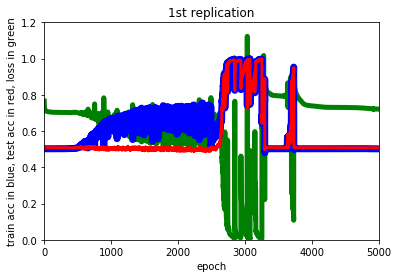

In [4]:
losses_1st_replication
plt.plot(losses_1st_replication, color='green', linewidth=5)
plt.plot(train_accuracies_1st_replication, color='blue', linewidth=7)
plt.plot(test_accuracies_1st_replication, color='red', linewidth=3)
plt.xlim(0, epochs)
plt.xlabel("epoch")
plt.ylim(0, 1.2)
plt.ylabel("train acc in blue, test acc in red, loss in green")
plt.title("1st replication")
plt.show()